In [1]:
import torch
import torch.backends.cudnn as cudnn
from torchvision import models
from data_aug.contrastive_learning_dataset import ContrastiveLearningDataset
from models.resnet_simclr import ResNetSimCLR
from simclr import SimCLR

In [2]:
import argparse
args = argparse.Namespace()
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.batch_size = 4
args.n_views = 2
args.temperature = 0.07
args.fp16_precision = False
args.arch = 'resnet18'
args.log_every_n_steps = 100
args.epochs = 1
args.disable_cuda = not torch.cuda.is_available()
args

Namespace(arch='resnet18', batch_size=4, device=device(type='cpu'), disable_cuda=True, epochs=1, fp16_precision=False, log_every_n_steps=100, n_views=2, temperature=0.07)

In [3]:
dataset = ContrastiveLearningDataset("./datasets")
train_dataset = dataset.get_dataset("stl10", args.n_views)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, drop_last=True)

Files already downloaded and verified


torch.Size([3, 96, 96])
torch.Size([3, 96, 96])
-1


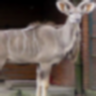

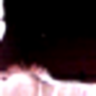

In [4]:
# 同一张图像经过两次随机的数据增强得到的正样本对
print(train_dataset[0][0][0].shape)
print(train_dataset[0][0][1].shape)
# unlabeled数据，label无意义
print(train_dataset[0][1])

from torchvision.transforms.functional import to_pil_image
from IPython.display import display
# 调整张量维度以符合 matplotlib 的期望格式：[高度, 宽度, 通道数]
image_pil = to_pil_image(train_dataset[0][0][0])
display(image_pil)
image_pil = to_pil_image(train_dataset[0][0][1])
display(image_pil)

In [5]:
model = ResNetSimCLR(base_model="resnet18", out_dim=128)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0, last_epoch=-1)

gpu_index = 0
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    gpu_index = -1
#  It’s a no-op if the 'gpu_index' argument is a negative integer or None.
with torch.cuda.device(gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simclr.train(train_loader)

  0%|          | 0/25000 [00:00<?, ?it/s]c:\Custom\Software\Environment\anaconda3\envs\simclr\lib\site-packages\torch\optim\lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  0%|          | 1/25000 [00:00<1:22:02,  5.08it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 3/25000 [00:00<1:16:39,  5.43it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 5/25000 [00:00<1:13:51,  5.64it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 7/25000 [00:01<1:10:54,  5.87it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 9/25000 [00:01<1:10:24,  5.92it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 11/25000 [00:01<1:11:25,  5.83it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 13/25000 [00:02<1:09:23,  6.00it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 15/25000 [00:02<1:12:08,  5.77it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 17/25000 [00:02<1:12:59,  5.71it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 19/25000 [00:03<1:09:48,  5.96it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 21/25000 [00:03<1:07:25,  6.18it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 23/25000 [00:03<1:04:31,  6.45it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 25/25000 [00:04<1:04:11,  6.48it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 27/25000 [00:04<1:04:03,  6.50it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 29/25000 [00:04<1:04:39,  6.44it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 31/25000 [00:05<1:03:40,  6.54it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 33/25000 [00:05<1:05:28,  6.35it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 35/25000 [00:05<1:08:20,  6.09it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 37/25000 [00:06<1:07:14,  6.19it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 39/25000 [00:06<1:07:29,  6.16it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 41/25000 [00:06<1:05:38,  6.34it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 43/25000 [00:07<1:04:56,  6.41it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 45/25000 [00:07<1:06:07,  6.29it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 47/25000 [00:07<1:07:12,  6.19it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 49/25000 [00:08<1:08:08,  6.10it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 51/25000 [00:08<1:06:15,  6.28it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 53/25000 [00:08<1:05:45,  6.32it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 55/25000 [00:08<1:09:01,  6.02it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 57/25000 [00:09<1:06:37,  6.24it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 59/25000 [00:09<1:06:54,  6.21it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 61/25000 [00:09<1:06:38,  6.24it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 63/25000 [00:10<1:06:06,  6.29it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 65/25000 [00:10<1:06:38,  6.24it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 67/25000 [00:10<1:06:52,  6.21it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 69/25000 [00:11<1:06:32,  6.24it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 71/25000 [00:11<1:11:00,  5.85it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 73/25000 [00:11<1:11:05,  5.84it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 75/25000 [00:12<1:08:44,  6.04it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 77/25000 [00:12<1:06:53,  6.21it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 79/25000 [00:12<1:05:06,  6.38it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 81/25000 [00:13<1:05:05,  6.38it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 83/25000 [00:13<1:05:56,  6.30it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 85/25000 [00:13<1:05:16,  6.36it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 87/25000 [00:14<1:10:30,  5.89it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 89/25000 [00:14<1:08:43,  6.04it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 91/25000 [00:14<1:07:15,  6.17it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 93/25000 [00:15<1:06:28,  6.24it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 95/25000 [00:15<1:06:19,  6.26it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 97/25000 [00:15<1:06:34,  6.23it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 99/25000 [00:16<1:06:52,  6.21it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 101/25000 [00:16<1:09:42,  5.95it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 103/25000 [00:16<1:08:03,  6.10it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 105/25000 [00:17<1:07:02,  6.19it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 107/25000 [00:17<1:08:31,  6.05it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 109/25000 [00:17<1:08:50,  6.03it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 111/25000 [00:18<1:07:54,  6.11it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 113/25000 [00:18<1:05:38,  6.32it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 115/25000 [00:18<1:09:37,  5.96it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 117/25000 [00:19<1:08:43,  6.03it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 119/25000 [00:19<1:07:43,  6.12it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 121/25000 [00:19<1:09:29,  5.97it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 123/25000 [00:20<1:09:07,  6.00it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


  0%|          | 125/25000 [00:20<1:10:00,  5.92it/s]

torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])
torch.Size([8, 128])
torch.Size([8, 7])
torch.Size([8])


In [ ]:
import torch.nn.functional as F
def info_nce_loss(features):

    labels = torch.cat([torch.arange(args.batch_size) for i in range(args.n_views)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    labels = labels.to(args.device)

    features = F.normalize(features, dim=1)

    similarity_matrix = torch.matmul(features, features.T)
    # assert similarity_matrix.shape == (
    #     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
    # assert similarity_matrix.shape == labels.shape

    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(args.device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
    # assert similarity_matrix.shape == labels.shape

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

    # select only the negatives the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(args.device)

    logits = logits / args.temperature
    return logits, labels

In [ ]:
features = torch.randn(args.batch_size * 2, 128)
logits, labels = info_nce_loss(features)
print(logits)
print(labels)

In [ ]:
features = torch.randn(args.batch_size * 2, 128)

labels = torch.cat([torch.arange(args.batch_size) for i in range(args.n_views)], dim=0)
print(labels.shape)
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
labels = labels.to(args.device)
print('labels:', labels.shape)
print(labels)
features = F.normalize(features, dim=1)

similarity_matrix = torch.matmul(features, features.T)
# assert similarity_matrix.shape == (
#     self.args.n_views * self.args.batch_size, self.args.n_views * self.args.batch_size)
# assert similarity_matrix.shape == labels.shape
print('similarity_matrix:', similarity_matrix.shape)
print(similarity_matrix)

# discard the main diagonal from both: labels and similarities matrix
mask = torch.eye(labels.shape[0], dtype=torch.bool).to(args.device)
print(mask)
labels = labels[~mask].view(labels.shape[0], -1)
print(labels)
similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
print(similarity_matrix)
# assert similarity_matrix.shape == labels.shape

# select and combine multiple positives
positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
print(positives)

# select only the negatives the negatives
negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
print(negatives)

logits = torch.cat([positives, negatives], dim=1)
labels = torch.zeros(logits.shape[0], dtype=torch.long).to(args.device)
print(logits)
print(labels)

logits = logits / args.temperature